# GPU LightGBM Baseline 
In this notebook, we present a GPU LightGBM baseline. In this notebook, compared to my previous starter notebooks we teach 5 new things:
* How to tranform `efs` and `efs_time` into single target with `KaplanMeierFitter`.
* How to train `GPU LightGBM model` with `KaplanMeierFitter` target
* How to train `XGBoost with Survivial:Cox loss`
* How to train `CatBoost with Survival:Cox loss`
* How to ensemble 5 models using `scipy.stats.rankdata()`.

# Two Competition Approaches
In this competition, there are two ways to train a Survival Model:
* We can input both `efs` and `efs_time` and train a **model that supports** `survival loss like Cox`.
* Transform `efs` and `efs_time` into a single target proxy for `risk score` and train **any model** with `regression loss like MSE`.

In this notebook, we train 5 models. The first 3 models (XGBoost, CatBoost, LightGBM) use bullet point two. And the next 2 models (XGBoost Cox, CatBoost Cox) use bullet point one. Discussion about this notebook is [here][4] and [here][3]. 

Since this competition's metric is a ranking metric, we ensemble the 5 predictions by first converting each into ranks using `scipy.stats.rankdata()`. Afterward we created a weighted average from the ranks.

Have Fun! Enjoy!

# Previous Notebooks
My previous starter notebooks are:
* XGBoost and CatBoost starter [here][1]
* NN (MLP) starter [here][2]

Associated discussions are [here][3], [here][4], [here][5]!

[1]: https://www.kaggle.com/code/cdeotte/xgboost-catboost-baseline-cv-668-lb-668
[2]: https://www.kaggle.com/code/cdeotte/nn-mlp-baseline-cv-670-lb-676
[3]: https://www.kaggle.com/competitions/equity-post-HCT-survival-predictions/discussion/550003
[4]: https://www.kaggle.com/competitions/equity-post-HCT-survival-predictions/discussion/550141
[5]: https://www.kaggle.com/competitions/equity-post-HCT-survival-predictions/discussion/550343

# Pip Install Libraries for Metric
Since internet must be turned off for submission, we pip install from my other notebook [here][1] where I downloaded the WHL files.

[1]: https://www.kaggle.com/code/cdeotte/pip-install-lifelines

# Load Train and Test

In [42]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

test = pd.read_csv("data/test.csv")
print("Test shape:", test.shape )

train = pd.read_csv("data/train.csv")
print("Train shape:",train.shape)
train.head()

Test shape: (3, 58)
Train shape: (28800, 60)


,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,Bone marrow,No,No,No,IEA,6.0,+/+,NaN,2.0,NaN,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2016,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,9.942,2.0,FKalone,No,M-F,2.0,More than one race,0.0,90.0,No,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,No,No,No,AML,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2008,No,Positive,No,Permissive,2.0,No,72.29,No,2.0,No,43.705,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,HIS,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2019,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,33.997,2.0,Cyclophosphamide alone,No,F-M,2.0,More than one race,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,ALL,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Intermediate,MAC,Not Hispanic or Latino,2009,No,Positive,No,Permissive,2.0,No,29.23,No,2.0,No,43.245,2.0,FK+ MMF +- others,No,M-M,2.0,White,0.0,90.0,Yes,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,No,No,No,MPN,6.0,+/+,10.0,2.0,NaN,5.0,2.0,No,2.0,2.0,PB,NaN,MAC,Hispanic or Latino,2018,No,NaN,Yes,NaN,2.0,No,56.81,No,2.0,No,29.740,2.0,TDEPLETION +- other,No,M-F,2.0,American Indian or Alaska Native,1.0,90.0,No,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223


# EDA on Train Targets
There are two train targets `efs` and `efs_time`. When `efs==1` we know patient **had an event** and we know time of event is `efs_time`. When `efs==0` we **do not know** if patient had an event or not, but we do know that patient was **without event for at least** `efs_time`.

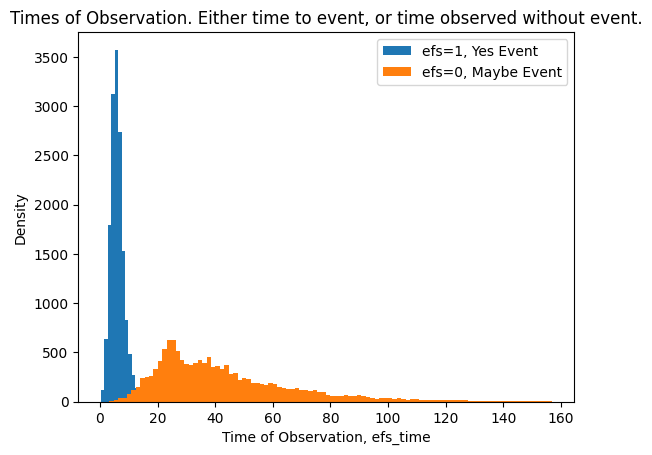

In [43]:
plt.hist(train.loc[train.efs==1,"efs_time"],bins=100,label="efs=1, Yes Event")
plt.hist(train.loc[train.efs==0,"efs_time"],bins=100,label="efs=0, Maybe Event")
plt.xlabel("Time of Observation, efs_time")
plt.ylabel("Density")
plt.title("Times of Observation. Either time to event, or time observed without event.")
plt.legend()
plt.show()

# Transform Two Targets into One Target with KaplanMeier!
Both targets `efs` and `efs_time` provide useful information. We will tranform these two targets into a single target to train our model with. In this competition we need to predict `risk score`. So we will create a target that mimics `risk score` to train our model. (Note this is only one out of many ways to transform two targets into one target. Considering experimenting on your own).

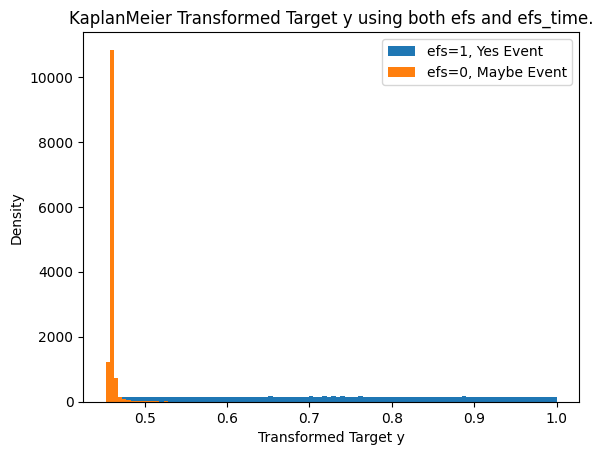

In [44]:
from lifelines import KaplanMeierFitter
def transform_survival_probability(df, time_col='efs_time', event_col='efs'):
    kmf = KaplanMeierFitter()
    kmf.fit(df[time_col], df[event_col])
    y = kmf.survival_function_at_times(df[time_col]).values
    return y
train["y"] = transform_survival_probability(train, time_col='efs_time', event_col='efs')

plt.hist(train.loc[train.efs==1,"y"],bins=100,label="efs=1, Yes Event")
plt.hist(train.loc[train.efs==0,"y"],bins=100,label="efs=0, Maybe Event")
plt.xlabel("Transformed Target y")
plt.ylabel("Density")
plt.title("KaplanMeier Transformed Target y using both efs and efs_time.")
plt.legend()
plt.show()

# Features
There are a total of 57 features. From these 35 are categorical and 22 are numerical. We will label encode the categorical features. Then our XGB and CAT model will accept these as categorical features and process them special internally. We leave the numerical feature NANs as NANs because GBDT (like XGB and CAT) can handle NAN and will use this information.

In [45]:
RMV = ["ID","efs","efs_time","y"]
FEATURES = [c for c in train.columns if not c in RMV]
print(f"There are {len(FEATURES)} FEATURES: {FEATURES}")

There are 57 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']


In [46]:
CATS = []
for c in FEATURES:
    if train[c].dtype=="object":
        CATS.append(c)
        train[c] = train[c].fillna("NAN")
        test[c] = test[c].fillna("NAN")
print(f"In these features, there are {len(CATS)} CATEGORICAL FEATURES: {CATS}")

In these features, there are 35 CATEGORICAL FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'cmv_status', 'tce_imm_match', 'rituximab', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'cardiac', 'pulm_moderate']


In [47]:
train_without_cats = train.drop(columns=CATS)
pd.DataFrame(train_without_cats)

,ID,hla_match_c_high,hla_high_res_8,hla_low_res_6,hla_high_res_6,hla_high_res_10,hla_match_dqb1_high,hla_nmdp_6,hla_match_c_low,hla_match_drb1_low,hla_match_dqb1_low,year_hct,hla_match_a_high,donor_age,hla_match_b_low,age_at_hct,hla_match_a_low,hla_match_b_high,comorbidity_score,karnofsky_score,hla_low_res_8,hla_match_drb1_high,hla_low_res_10,efs,efs_time,y
0,0,NaN,NaN,6.0,6.0,NaN,2.0,6.0,2.0,2.0,2.0,2016,2.0,NaN,2.0,9.942,2.0,2.0,0.0,90.0,8.0,2.0,10.0,0.0,42.356,0.458687
1,1,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,2.0,2008,2.0,72.290,2.0,43.705,2.0,2.0,3.0,90.0,8.0,2.0,10.0,1.0,4.672,0.847759
2,2,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,2.0,2019,2.0,NaN,2.0,33.997,2.0,2.0,0.0,90.0,8.0,2.0,10.0,0.0,19.793,0.462424
3,3,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,2.0,2009,2.0,29.230,2.0,43.245,2.0,2.0,0.0,90.0,8.0,2.0,10.0,0.0,102.349,0.456661
4,4,2.0,8.0,6.0,6.0,10.0,2.0,5.0,2.0,2.0,2.0,2018,2.0,56.810,2.0,29.740,2.0,2.0,1.0,90.0,8.0,2.0,10.0,0.0,16.223,0.464674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28795,28795,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,2.0,2018,2.0,24.212,2.0,51.136,2.0,2.0,0.0,NaN,8.0,2.0,10.0,0.0,18.633,0.462846
28796,28796,1.0,4.0,5.0,3.0,6.0,2.0,4.0,1.0,2.0,2.0,2017,1.0,30.770,1.0,18.075,2.0,1.0,3.0,90.0,6.0,1.0,8.0,1.0,4.892,0.825494
28797,28797,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,2.0,2018,2.0,22.627,2.0,51.005,2.0,2.0,5.0,90.0,8.0,2.0,10.0,0.0,23.157,0.461142
28798,28798,1.0,4.0,3.0,3.0,5.0,1.0,3.0,1.0,1.0,1.0,2018,1.0,58.074,1.0,0.044,1.0,1.0,1.0,90.0,4.0,1.0,5.0,0.0,52.351,0.458404


In [48]:
combined = pd.concat([train,test],axis=0,ignore_index=True)
#print("Combined data shape:", combined.shape )

In [49]:
print(combined.shape)
# Feature Engineering: Count missing values per row
combined['missing_count'] = combined.isnull().sum(axis=1)

# Feature Engineering: Combine HLA match scores into a single metric
hla_cols = [
    'hla_high_res_6', 'hla_high_res_8', 'hla_high_res_10',
    'hla_match_a_high', 'hla_match_b_high', 'hla_match_c_high',
    'hla_match_dqb1_high', 'hla_low_res_6', 'hla_low_res_8'
]
combined['hla_match_avg'] = combined[hla_cols].mean(axis=1)

# Feature Engineering: Binary feature for high-risk DRI scores
combined['dri_high_risk'] = combined['dri_score'].apply(
    lambda x: 1 if isinstance(x, str) and ('High' in x or 'Very high' in x) else 0
)

# Feature Engineering: Binary feature for any psychiatric disturbance
combined['psych_disturb_binary'] = combined['psych_disturb'].apply(lambda x: 1 if x == 'Yes' else 0)

# Feature Engineering: Create a composite comorbidity score
comorbidity_cols = [
    'cardiac', 'renal_issue', 'hepatic_severe', 'pulm_severe', 
    'rheum_issue', 'diabetes', 'obesity', 'vent_hist', 'arrhythmia'
]
combined['comorbidity_severity'] = combined[comorbidity_cols].apply(
    lambda row: sum([1 for val in row if val == 'Yes']), axis=1
)

# Feature Engineering: Binary feature for severe conditions
combined['severe_conditions'] = combined[['hepatic_severe', 'pulm_severe', 'renal_issue']].apply(
    lambda row: 1 if 'Yes' in row.values else 0, axis=1
)

# Feature Engineering: Encode donor-recipient sex match as numerical categories
sex_match_mapping = {'M-M': 0, 'F-F': 1, 'M-F': 2, 'F-M': 3, np.nan: -1}
combined['sex_match_encoded'] = combined['sex_match'].map(sex_match_mapping)

# Feature Engineering: Create interaction features
combined['hla_cyto_interaction'] = combined['hla_match_c_high'] * combined['cyto_score'].apply(
    lambda x: 1 if x == 'Favorable' else 0
)

# Feature Engineering: Extract year from 'year_hct' and categorize into decades
combined['year_hct_decade'] = combined['year_hct'].apply(lambda x: (x // 10) * 10 if not pd.isnull(x) else np.nan)

# Feature Engineering: Add a risk index based on comorbidity and DRI
combined['risk_index'] = combined['comorbidity_score'] + combined['dri_high_risk']

# Feature Engineering: Binarize CMV status
combined['cmv_positive'] = combined['cmv_status'].apply(lambda x: 1 if x in ['+/-', '+/+'] else 0)
print(combined.shape)

In [50]:
# LABEL ENCODE CATEGORICAL FEATURES
FEATURES = [c for c in train.columns if not c in RMV]
print("We LABEL ENCODE the CATEGORICAL FEATURES: ",end="")
for c in FEATURES:

    # LABEL ENCODE CATEGORICAL AND CONVERT TO INT32 CATEGORY
    if c in CATS:
        print(f"{c}, ",end="")
        combined[c],_ = combined[c].factorize()
        combined[c] -= combined[c].min()
        combined[c] = combined[c].astype("int32")
        combined[c] = combined[c].astype("category")
        
    # REDUCE PRECISION OF NUMERICAL TO 32BIT TO SAVE MEMORY
    else:
        if combined[c].dtype=="float64":
            combined[c] = combined[c].astype("float32")
        if combined[c].dtype=="int64":
            combined[c] = combined[c].astype("int32")
    
train = combined.iloc[:len(train)].copy()
test = combined.iloc[len(train):].reset_index(drop=True).copy()

We LABEL ENCODE the CATEGORICAL FEATURES: dri_score, psych_disturb, cyto_score, diabetes, tbi_status, arrhythmia, graft_type, vent_hist, renal_issue, pulm_severe, prim_disease_hct, cmv_status, tce_imm_match, rituximab, prod_type, cyto_score_detail, conditioning_intensity, ethnicity, obesity, mrd_hct, in_vivo_tcd, tce_match, hepatic_severe, prior_tumor, peptic_ulcer, gvhd_proph, rheum_issue, sex_match, race_group, hepatic_mild, tce_div_match, donor_related, melphalan_dose, cardiac, pulm_moderate, 

# XGBoost with KaplanMeier
We train XGBoost model for 10 folds and achieve **CV 0.674**!

In [51]:
from sklearn.model_selection import KFold
from xgboost import XGBRegressor, XGBClassifier
import xgboost as xgb
print("Using XGBoost version",xgb.__version__)

Using XGBoost version 2.1.3


In [52]:
%%time
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
oof_xgb = np.zeros(len(train))
pred_xgb = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y"]
    x_test = test[FEATURES].copy()

    model_xgb = XGBRegressor(
        device="cuda",
        max_depth=3,  
        colsample_bytree=0.5,  
        subsample=0.8,  
        n_estimators=2000,  
        learning_rate=0.02,  
        enable_categorical=True,
        min_child_weight=80,
        #early_stopping_rounds=25,
    )
    model_xgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],  
        verbose=500 
    )

    # INFER OOF
    oof_xgb[test_index] = model_xgb.predict(x_valid)
    # INFER TEST
    pred_xgb += model_xgb.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_xgb /= FOLDS

#########################
### Fold 1
#########################
[0]	validation_0-rmse:0.17783
[500]	validation_0-rmse:0.15962
[1000]	validation_0-rmse:0.15752
[1500]	validation_0-rmse:0.15660
[1999]	validation_0-rmse:0.15609
#########################
### Fold 2
#########################
[0]	validation_0-rmse:0.17363
[500]	validation_0-rmse:0.15573
[1000]	validation_0-rmse:0.15416
[1500]	validation_0-rmse:0.15352
[1999]	validation_0-rmse:0.15314
#########################
### Fold 3
#########################
[0]	validation_0-rmse:0.17735
[500]	validation_0-rmse:0.15801
[1000]	validation_0-rmse:0.15616
[1500]	validation_0-rmse:0.15545
[1999]	validation_0-rmse:0.15505
#########################
### Fold 4
#########################
[0]	validation_0-rmse:0.17931
[500]	validation_0-rmse:0.16008
[1000]	validation_0-rmse:0.15799
[1500]	validation_0-rmse:0.15713
[1999]	validation_0-rmse:0.15666
#########################
### Fold 5
#########################
[0]	validation_0-rmse:0.17376
[500]	valid

In [53]:
from metric import score

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_xgb
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for XGBoost KaplanMeier =",m)

c:\Users\yardz\Documents\mlbook\kaggle comps\CIBMTR - Equity in post-HCT Survival Predictions\metric.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for XGBoost KaplanMeier = 0.67339759730264


In [54]:
pred_xgb

array([0.49167998, 0.631201  , 0.43218473])

In [55]:
'''Overall CV for XGBoost KaplanMeier = 0.67339759730264'''

'Overall CV for XGBoost KaplanMeier = 0.67339759730264'

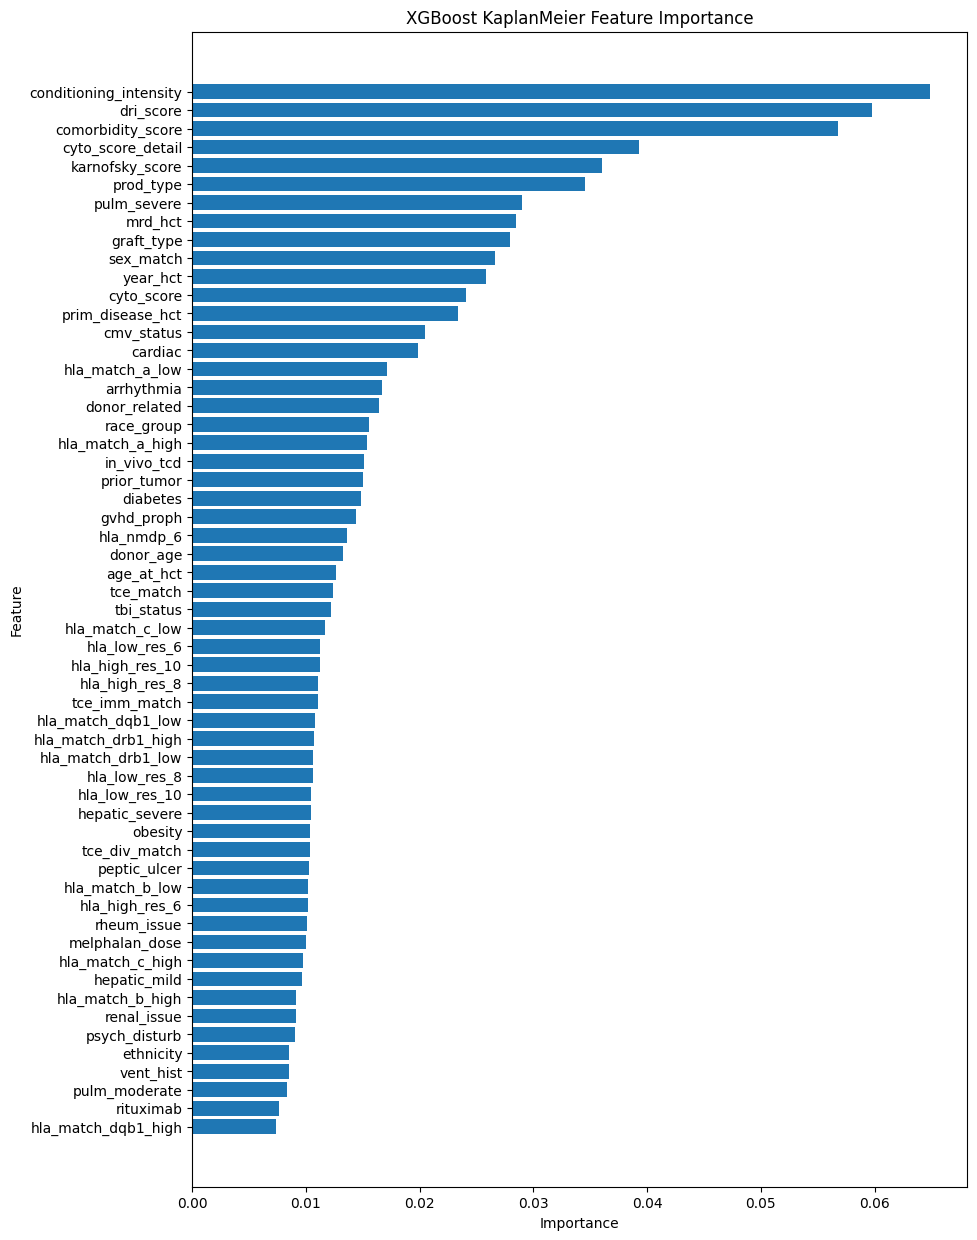

In [56]:
feature_importance = model_xgb.feature_importances_
importance_df = pd.DataFrame({
    "Feature": FEATURES,  # Replace FEATURES with your list of feature names
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 15))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("XGBoost KaplanMeier Feature Importance")
plt.gca().invert_yaxis()  # Flip features for better readability
plt.show()

# CatBoost with KaplanMeier
We train CatBoost model for 10 folds and achieve **CV 0.674**!

In [57]:
from catboost import CatBoostRegressor, CatBoostClassifier
import catboost as cb
print("Using CatBoost version",cb.__version__)

Using CatBoost version 1.2.7


In [58]:
%%time
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
oof_cat = np.zeros(len(train))
pred_cat = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y"]
    x_test = test[FEATURES].copy()

    model_cat = CatBoostRegressor(
        task_type="GPU",  
        learning_rate=0.1,    
        grow_policy='Lossguide',
        #early_stopping_rounds=25,
    )
    model_cat.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=250)

    # INFER OOF
    oof_cat[test_index] = model_cat.predict(x_valid)
    # INFER TEST
    pred_cat += model_cat.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat /= FOLDS

#########################
### Fold 1
#########################
0:	learn: 0.1743389	test: 0.1759977	best: 0.1759977 (0)	total: 14.8ms	remaining: 14.8s
250:	learn: 0.1413894	test: 0.1575265	best: 0.1575265 (250)	total: 3.17s	remaining: 9.46s
500:	learn: 0.1323377	test: 0.1569265	best: 0.1569142 (484)	total: 6.28s	remaining: 6.26s
750:	learn: 0.1245977	test: 0.1570549	best: 0.1568170 (608)	total: 9.39s	remaining: 3.12s


KeyboardInterrupt: 

In [ ]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost KaplanMeier =",m)

c:\Users\yardz\Documents\mlbook\kaggle comps\CIBMTR - Equity in post-HCT Survival Predictions\metric.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for CatBoost KaplanMeier = 0.6724408792074619


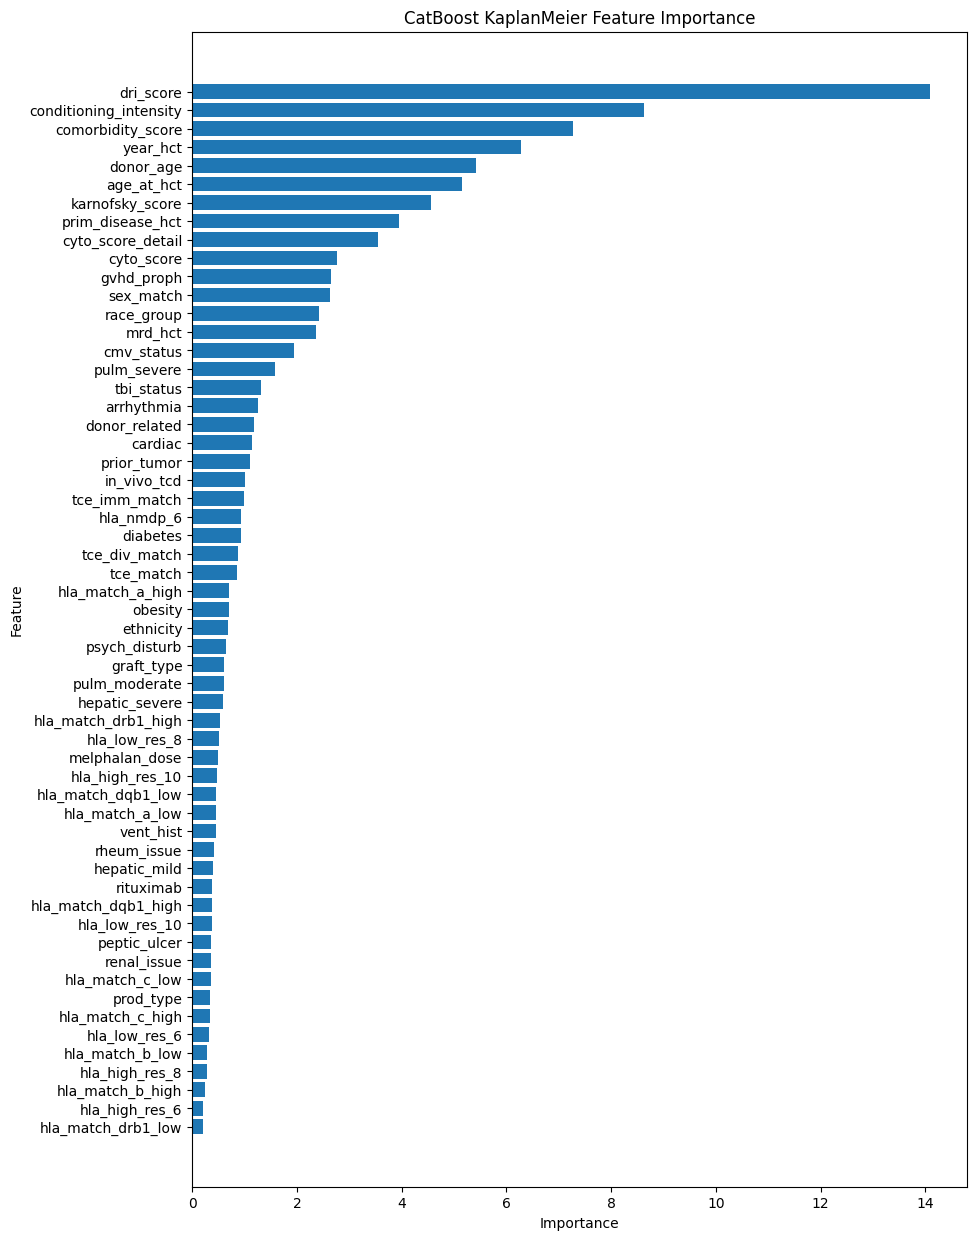

In [ ]:
feature_importance = model_cat.get_feature_importance()
importance_df = pd.DataFrame({
    "Feature": FEATURES, 
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 15))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("CatBoost KaplanMeier Feature Importance")
plt.gca().invert_yaxis()  # Flip features for better readability
plt.show()

# LightGBM with KaplanMeier
We train LightGBM model for 10 folds and achieve **CV 0.6725**!

In [ ]:
from lightgbm import LGBMRegressor
import lightgbm as lgb
print("Using LightGBM version",lgb.__version__)

Using LightGBM version 4.5.0


In [ ]:
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y"]    
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y"]
    x_test = test[FEATURES].copy()

    model_lgb = LGBMRegressor(
        device="gpu", 
        max_depth=3, 
        colsample_bytree=0.4,  
        #subsample=0.9, 
        n_estimators=2500, 
        learning_rate=0.02, 
        objective="regression", 
        verbose=-1, 
        #early_stopping_rounds=25,
    )
    model_lgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
    )
    
    # INFER OOF
    oof_lgb[test_index] = model_lgb.predict(x_valid)
    # INFER TEST
    pred_lgb += model_lgb.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_lgb /= FOLDS

#########################
### Fold 1
#########################


c:\Users\yardz\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\yardz\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\yardz\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\yardz\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  

#########################
### Fold 2
#########################
#########################
### Fold 3
#########################
#########################
### Fold 4
#########################
#########################
### Fold 5
#########################
#########################
### Fold 6
#########################
#########################
### Fold 7
#########################
#########################
### Fold 8
#########################
#########################
### Fold 9
#########################
#########################
### Fold 10
#########################


In [ ]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_lgb
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for LightGBM KaplanMeier =",m)

c:\Users\yardz\Documents\mlbook\kaggle comps\CIBMTR - Equity in post-HCT Survival Predictions\metric.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for LightGBM KaplanMeier = 0.6725173671119267


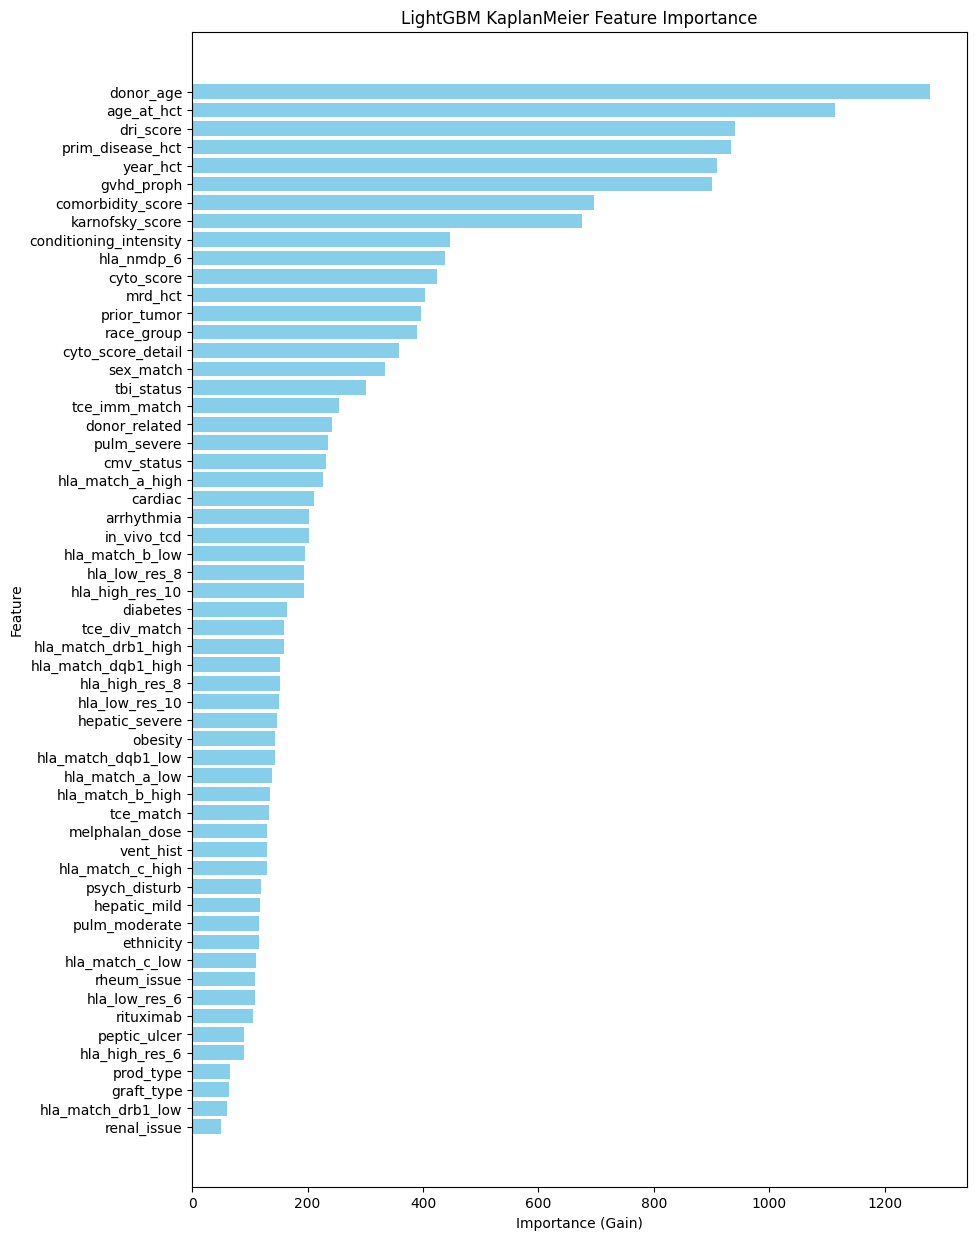

In [ ]:
feature_importance = model_lgb.feature_importances_ 
importance_df = pd.DataFrame({
    "Feature": FEATURES,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 15))
plt.barh(importance_df["Feature"], importance_df["Importance"], color='skyblue')
plt.xlabel("Importance (Gain)")
plt.ylabel("Feature")
plt.title("LightGBM KaplanMeier Feature Importance")
plt.gca().invert_yaxis()  # Flip features for better readability
plt.show()

# XGBoost with Survival:Cox
We train XGBoost using Survival:Cox loss for 10 folds and achieve **CV=672**!

In [40]:
# SURVIVAL COX NEEDS THIS TARGET (TO DIGEST EFS AND EFS_TIME)
train["efs_time2"] = train.efs_time.copy()
train.loc[train.efs==0,"efs_time2"] *= -1

In [ ]:
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
oof_xgb_cox = np.zeros(len(train))
pred_xgb_cox = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"efs_time2"]    
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"efs_time2"]
    x_test = test[FEATURES].copy()

    model_xgb_cox = XGBRegressor(
        device="cuda",
        max_depth=3,  
        colsample_bytree=0.5,  
        subsample=0.8,  
        n_estimators=2000,  
        learning_rate=0.02,  
        enable_categorical=True,
        min_child_weight=80,
        objective='survival:cox',
        eval_metric='cox-nloglik',
    )
    model_xgb_cox.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],  
        verbose=500  
    )
    
    # INFER OOF
    oof_xgb_cox[test_index] = model_xgb_cox.predict(x_valid)
    # INFER TEST
    pred_xgb_cox += model_xgb_cox.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_xgb_cox /= FOLDS

#########################
### Fold 1
#########################
[0]	validation_0-cox-nloglik:7.62530
[500]	validation_0-cox-nloglik:7.43349
[1000]	validation_0-cox-nloglik:7.41697
[1500]	validation_0-cox-nloglik:7.41101
[1999]	validation_0-cox-nloglik:7.40840
#########################
### Fold 2
#########################
[0]	validation_0-cox-nloglik:7.61840
[500]	validation_0-cox-nloglik:7.41088
[1000]	validation_0-cox-nloglik:7.39690
[1500]	validation_0-cox-nloglik:7.39101
[1999]	validation_0-cox-nloglik:7.38823
#########################
### Fold 3
#########################
[0]	validation_0-cox-nloglik:7.61061
[500]	validation_0-cox-nloglik:7.40567
[1000]	validation_0-cox-nloglik:7.39170
[1500]	validation_0-cox-nloglik:7.38731
[1999]	validation_0-cox-nloglik:7.38676
#########################
### Fold 4
#########################
[0]	validation_0-cox-nloglik:7.60592
[500]	validation_0-cox-nloglik:7.41103
[1000]	validation_0-cox-nloglik:7.40040
[1500]	validation_0-cox-nloglik:7.39846


KeyboardInterrupt: 

In [23]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_xgb_cox
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for XGBoost Survival:Cox =",m)

c:\Users\yardz\Documents\mlbook\kaggle comps\CIBMTR - Equity in post-HCT Survival Predictions\metric.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for XGBoost Survival:Cox = 0.6721210119282028


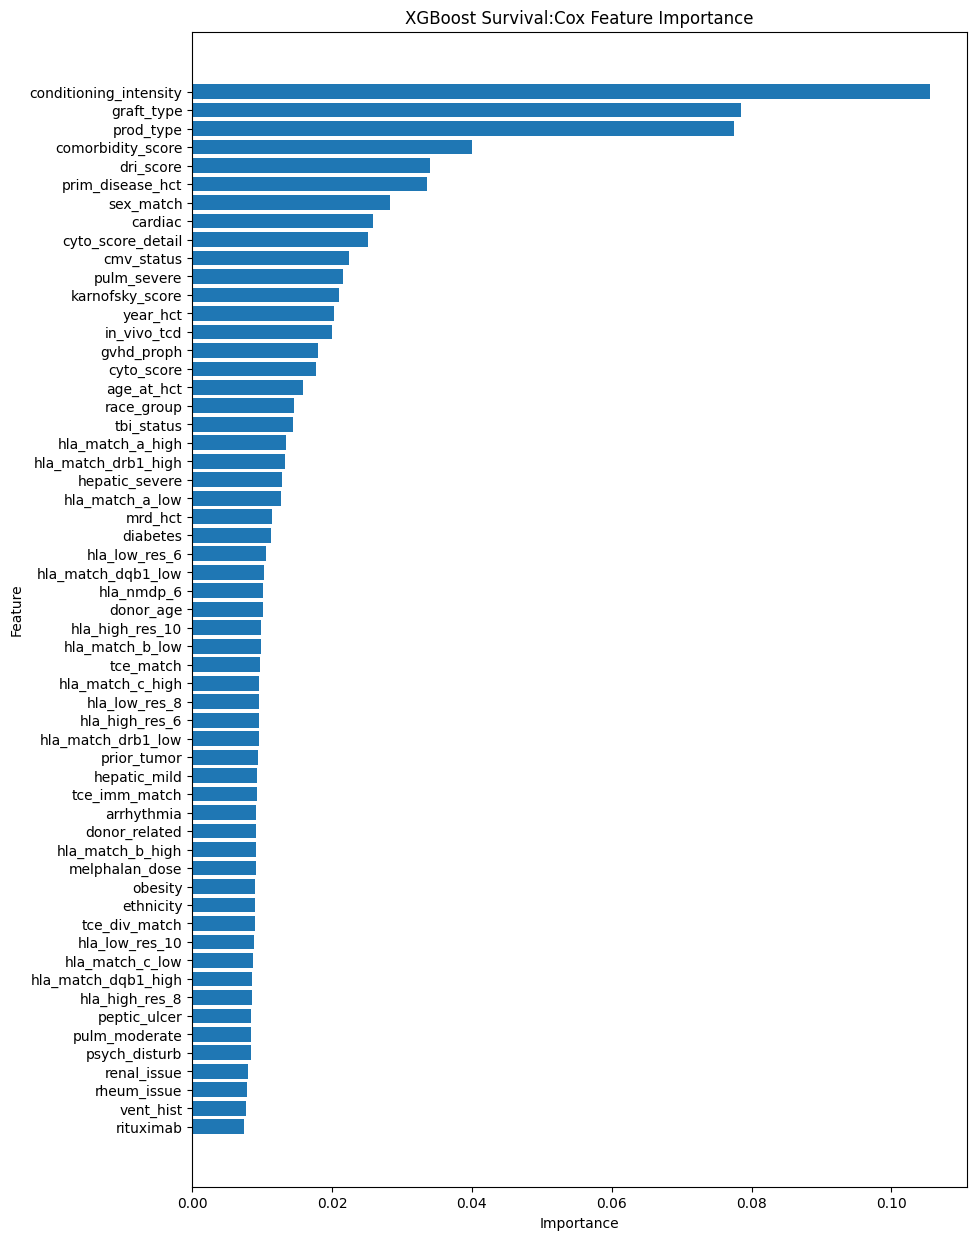

In [24]:
feature_importance = model_xgb_cox.feature_importances_
importance_df = pd.DataFrame({
    "Feature": FEATURES,  # Replace FEATURES with your list of feature names
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 15))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("XGBoost Survival:Cox Feature Importance")
plt.gca().invert_yaxis()  # Flip features for better readability
plt.show()

# CatBoost with Survival:Cox
We train CatBoost using Survival:Cox loss for 10 folds and achieve **CV=671**!

In [25]:
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
oof_cat_cox = np.zeros(len(train))
pred_cat_cox = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"efs_time2"]    
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"efs_time2"]
    x_test = test[FEATURES].copy()

    model_cat_cox = CatBoostRegressor(
        loss_function="Cox",
        #task_type="GPU",   
        iterations=400,     
        learning_rate=0.1,  
        grow_policy='Lossguide',
        use_best_model=False,
    )
    model_cat_cox.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=100)
    
    # INFER OOF
    oof_cat_cox[test_index] = model_cat_cox.predict(x_valid)
    # INFER TEST
    pred_cat_cox += model_cat_cox.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_cox /= FOLDS

#########################
### Fold 1
#########################
0:	learn: -137204.2010418	test: -11625.0126498	best: -11625.0126498 (0)	total: 149ms	remaining: 59.5s
100:	learn: -134245.0940003	test: -11368.0935757	best: -11367.7720241 (99)	total: 15s	remaining: 44.5s
200:	learn: -133569.4247640	test: -11357.0053940	best: -11356.8330165 (182)	total: 29.7s	remaining: 29.4s
300:	learn: -133095.7842781	test: -11351.1819262	best: -11351.0222775 (299)	total: 44.1s	remaining: 14.5s
399:	learn: -132763.5913301	test: -11349.4816640	best: -11349.4142821 (327)	total: 57.5s	remaining: 0us

bestTest = -11349.41428
bestIteration = 327

#########################
### Fold 2
#########################
0:	learn: -137014.2912101	test: -11772.8856048	best: -11772.8856048 (0)	total: 152ms	remaining: 1m
100:	learn: -134091.3022715	test: -11485.4489792	best: -11485.3225232 (99)	total: 14.9s	remaining: 44s
200:	learn: -133312.7852628	test: -11460.6629034	best: -11460.6629034 (200)	total: 29.9s	remaining: 29.6s

In [26]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_cox
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost Survival:Cox =",m)

c:\Users\yardz\Documents\mlbook\kaggle comps\CIBMTR - Equity in post-HCT Survival Predictions\metric.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for CatBoost Survival:Cox = 0.6707201522843004


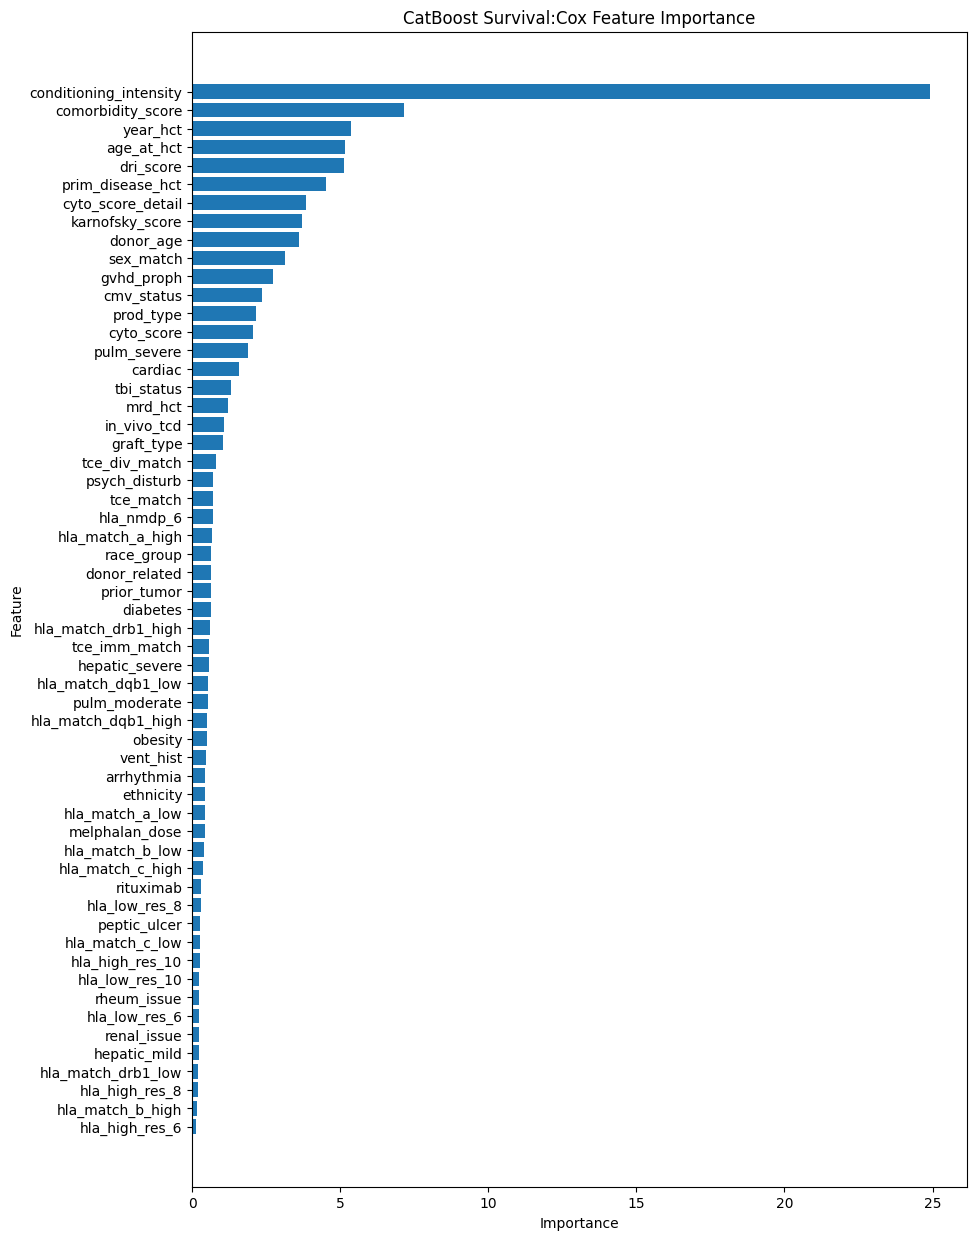

In [27]:
feature_importance = model_cat_cox.get_feature_importance()
importance_df = pd.DataFrame({
    "Feature": FEATURES, 
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 15))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("CatBoost Survival:Cox Feature Importance")
plt.gca().invert_yaxis()  # Flip features for better readability
plt.show()

# Ensemble CAT and XGB and LGB
We ensemble our XGBoost, CatBoost, LightGBM, XGBoost Cox, and CatBoost Cox using `scipy.stats.rankdata()` and achieve an amazing **CV=0.681** Wow!

In [28]:
from scipy.stats import rankdata 

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = rankdata(oof_xgb) + rankdata(oof_cat) + rankdata(oof_lgb)\
                     + rankdata(oof_xgb_cox) + rankdata(oof_cat_cox)
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for Ensemble =",m)

c:\Users\yardz\Documents\mlbook\kaggle comps\CIBMTR - Equity in post-HCT Survival Predictions\metric.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for Ensemble = 0.6806280874479907


# Create Submission CSV

In [29]:
sub = pd.read_csv("data/sample_submission.csv")
sub.prediction = rankdata(pred_xgb) + rankdata(pred_cat) + rankdata(pred_lgb)\
                     + rankdata(pred_xgb_cox) + rankdata(pred_cat_cox)
sub.to_csv("submission.csv",index=False)
print("Sub shape:",sub.shape)
sub.head()

Sub shape: (3, 2)


,ID,prediction
0,28800,10.0
1,28801,15.0
2,28802,5.0
